In [32]:
import json
import glob
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [33]:
save_dir = '/home/hanna/MS-suppl/files/'
files = glob.glob(save_dir + '*ERA5*.json')

In [34]:
files

['/home/hanna/MS-suppl/files/ERA5_grid_resample_includes_changes_to_indexes_from_50.0_55.0.json',
 '/home/hanna/MS-suppl/files/ERA5_grid_resample_includes_changes_to_indexes_from_35.0_40.0.json',
 '/home/hanna/MS-suppl/files/ERA5_grid_resample_includes_changes_to_indexes_from_40.0_45.0.json',
 '/home/hanna/MS-suppl/files/ERA5_grid_resample_includes_changes_to_indexes_from_30.0_35.0.json',
 '/home/hanna/MS-suppl/files/ERA5_grid_resample_includes_changes_to_indexes_from_45.0_50.0.json']

In [35]:
def get_dict_with_all_keys():
    ex_fil = glob.glob(save_dir + '*ERA5*.json')
    #print(ex_fil)
    merged_dict = {}
    for fil in ex_fil:
        with open(fil, 'r') as f:
            data_grid = json.load(f)
        merged_dict.update(data_grid)   
    return merged_dict

In [36]:
data_grid = get_dict_with_all_keys()

In [37]:
def read_dlon_dlat():
    nc_files = glob.glob('/home/hanna/MS-suppl/'+'*small*.json')
    print(nc_files)
    
    with open(nc_files[-1]) as f:
        d =  json.load(f)
        
    d_phi      = d['dphi'] 
    d_theta    = d['dtheta'] 
    cell_areas = d['cell_area']
    lat_array  = d['lat'] 
    lon_array  = d['lon']

    return d_phi, d_theta, cell_areas, lat_array, lon_array

In [40]:
d_phi, d_theta, cell_areas, lat_array, lon_array = read_dlon_dlat()

['/home/hanna/MS-suppl/smaller_changes_lat_lon.json']


In [50]:
lat = '30.25'
lon = '19.25'

lat = '52.5'
lon = '27.5'

subset = data_grid[lat][lon]

In [51]:
subset

{'centre': {'index': [12604649,
   12604650,
   12604651,
   12608360,
   12608361,
   12608362,
   12608363,
   12612072,
   12612073,
   12612074,
   12615783,
   12615784,
   12615785],
  'area': [4.188149258453053,
   4.193815026918698,
   4.199217043244294,
   4.196536272247417,
   4.202271147366084,
   4.207874328008221,
   4.21341034037004,
   4.21076716926,
   4.216435184082651,
   4.222108472073302,
   4.219367232976641,
   4.224972081200086,
   4.230778341051892]},
 'down': {'index': [12600938, 12600939, 12600940],
  'area': [0.7629532365066963, 1.07453645580619, 1.3876369724046786]},
 'up': {'index': [], 'area': []},
 'right': {'index': [12604652, 12608364, 12612075],
  'area': [3.8065038338790944, 0.5221556303025091, 1.4387007683424107]},
 'left': {'index': [12604648, 12608359, 12612071, 12615782],
  'area': [1.5082267203817468,
   0.5676240854604291,
   3.8359329170775758,
   2.9115155070030343]},
 'corner': {'index': [12600941, 12600937, 12615786],
  'area': [1.1650089377

In [47]:
len(lat_array), len(lon_array)

(645166, 645166)

In [41]:
def plot(lat = '30.25', lon = '19.0'):
    ex1 = data_grid[lat][lon]
    c_lat = [lat_array[i] for i in ex1['corner']['index']]
    c_lon = [lon_array[i] for i in ex1['corner']['index']]
    counter = 0
    for lat, lon in zip(c_lat, c_lon):
        plt.scatter(lat, lon, label = str(counter))
        counter += 1
    plt.scatter(float(lat), float(lon))
    plt.legend()
    return plt.show()

In [ ]:

import glob
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import datetime
from netCDF4 import Dataset # used for the netcdf files which contain lat, lon.
import seaborn as sns
import pandas as pd

class Resample:

    def __init__(self):

        self.path_grb      = '//uio/lagringshotell/geofag/students/metos/hannasv/satelite_data_raw/'
        self.path_era  = '//uio/lagringshotell/geofag/students/metos/hannasv/era_interim_data/'
        self.nc_path   = '//uio/lagringshotell/geofag/students/metos/hannasv/satelite_coordinates/'
        # Update
        self.store_dir = '//uio/lagringshotell/geofag/students/metos/hannasv/satelite_coordinates/'

        nc_files  = glob.glob(self.nc_path + '*.nc')
        grb_files = glob.glob(self.path_grb + "*.grb")
        grb_files = glob.glob(self.path_grb + "*.grb")
        era       = glob.glob(self.path_era + "*q.nc")

        self.grb_file = grb_files[0]
        self.era_file = era[0]
        self.nc_file = nc_files[0]

        self.data = xr.open_dataset(self.grb_file, engine = "pynio")
        self.era = xr.open_dataset(self.era_file)

        return

    def compute_dlat_dlon(self, save_file = False):
        rootgrp = Dataset(self.nc_file, "r", format="NETCDF4")
        cloud_mask_array = rootgrp.variables["cloudMask"][:].data
        lat_array = rootgrp.variables["lat"][:].data
        lon_array = rootgrp.variables["lon"][:].data
        lat_array[lat_array < -99] = np.nan # updates of disk values to nan
        lon_array[lon_array < -99] = np.nan # updates of disk values to nan
        d_phi   = np.zeros(np.shape(lat_array))
        d_theta = np.zeros(np.shape(lat_array))

        for i in range(1, 3711):
            for j in range(1, 3711):
                d_phi[i][j] = ( np.abs(lon_array[i-1][j]) - np.abs(lon_array[i+1][j]) )/4
                d_theta[i][j] = ( np.abs(lat_array[i][j-1]) - np.abs(lat_array[i][j+1]) )/4

        dictionary = {'lon': lon_array.reshape(-1),
                      'lat': lat_array.reshape(-1),
                      'dlat':  d_theta.reshape(-1),
                      'dlon': d_phi.reshape(-1)}

        df = pd.DataFrame.from_dict(dictionary)
        if save_file:
            df.to_csv( '~/Desktop/lat_lon_dlat_dlon.csv' )

        return

    def area_grid_cell(self, c_lat, d_lat, d_lon):
        """
        c_lat : float
            Centre point longitude, latitude in degrees

        d_lat, d_lon : float
            delta lat lon in degrees

        Returns : area in km^2

        cdo : If the grid cell area have to be computed it is scaled with the earth radius to square meters.
        """
        R = 6371000  # in M
        # area er egentlig R**2
        area = R*(-np.sin((c_lat - d_lat)*np.pi/180)+np.sin((c_lat + d_lat)*np.pi/180) )*(2*d_lon*np.pi/180) # R**2
        return area


    def compute_area_one_cell(self, lat = 30, lon = -15):
        era_AREA = self.area_grid_cell(lat, 0.375, 0.375)
        coord_info = pd.read_csv('~/Desktop/lat_lon_dlat_dlon.csv')

        c_lat = coord_info.lat.values
        c_lon = coord_info.lon.values
        d_phi = coord_info.d_lon.values
        d_theta = coord_info.dlat.values

        # Make this a loop over lat_lons?
        lat_bondaries = np.array([[lon],
                                  [lat]])

        BOUND =  np.array([[-0.75/2, 0.75/2],
                           [-0.75/2, 0.75/2]])

        ranges = lat_bondaries + BOUND

        lon_range = ranges[0, :]
        lat_range = ranges[1, :]
        min_lon, max_lon = lon_range
        min_lat, max_lat = lat_range

        #d_phi   = d_phi.reshape(-1)
        #d_theta = d_theta.reshape(-1)

        era_up    = ranges[1, 1]
        era_down  = ranges[1, 0]
        era_left  = ranges[0, 0]
        era_right = ranges[0, 1]

        #c_lon = lon_array.reshape(-1) #+ d_phi
        #c_lat = lat_array.reshape(-1) #+ d_theta

        cmk_left  = c_lon - np.abs(d_phi)   #- era_right
        cmk_right = c_lon + np.abs(d_phi)   #- era_left

        # TODO : Sjekk d theta og lignende.
        cmk_up    = c_lat + np.abs(d_theta) #- era_down
        cmk_down  = c_lat - np.abs(d_theta) #- era_up

        idx_left_boundary  = np.intersect1d(np.argwhere(cmk_right > era_left),  np.argwhere(cmk_left < era_left) )
        idx_right_boundary = np.intersect1d(np.argwhere(cmk_right > era_right), np.argwhere(cmk_left < era_right) )
        idx_up_boundary    = np.intersect1d(np.argwhere(cmk_up > era_up), np.argwhere(cmk_down < era_up) )
        idx_down_boundary  = np.intersect1d(np.argwhere(cmk_up > era_down), np.argwhere(cmk_down < era_down) )

        lower_right_corner = np.intersect1d(idx_down_boundary, idx_right_boundary)
        lower_left_corner  = np.intersect1d(idx_down_boundary, idx_left_boundary)
        upper_left_corner  = np.intersect1d(idx_up_boundary, idx_left_boundary)
        upper_right_corner = np.intersect1d(idx_up_boundary, idx_right_boundary)

        corner_idx         = np.concatenate([lower_right_corner, lower_left_corner,
                                             upper_left_corner, upper_right_corner]) # corner idx

        max_lon, min_lon = np.max(c_lon[corner_idx]), np.min(c_lon[corner_idx])
        max_lat, min_lat = np.max(c_lat[corner_idx]), np.min(c_lat[corner_idx])

        # removes corners
        idx_down_boundary = idx_down_boundary[idx_down_boundary != lower_right_corner]
        idx_down_boundary = idx_down_boundary[idx_down_boundary != lower_left_corner]

        idx_up_boundary = idx_up_boundary[idx_up_boundary != upper_right_corner]
        idx_up_boundary = idx_up_boundary[idx_up_boundary != upper_left_corner]

        idx_left_boundary = idx_left_boundary[idx_left_boundary != upper_left_corner]
        idx_left_boundary = idx_left_boundary[idx_left_boundary != lower_left_corner]

        idx_right_boundary = idx_right_boundary[idx_right_boundary != upper_right_corner]
        idx_right_boundary = idx_right_boundary[idx_right_boundary != lower_right_corner]

        # subsection left boundary OLD
        low_bound = np.argwhere( c_lat[idx_left_boundary] > min_lat  )
        up_bound  = np.argwhere( c_lat[idx_left_boundary] < max_lat  )
        sub_section_left = np.intersect1d(low_bound, up_bound)

        # subsection right boundary
        low_bound = np.argwhere( c_lat[idx_right_boundary] > min_lat )
        up_bound  = np.argwhere( c_lat[idx_right_boundary] < max_lat)
        sub_section_right = np.intersect1d(low_bound, up_bound)

        # Subsection Down Boundary
        one = np.argwhere( c_lon[idx_down_boundary] > min_lon )
        two = np.argwhere( c_lon[idx_down_boundary] < max_lon)
        sub_section_down = np.intersect1d(one, two)

        # subsection up boundary
        one = np.argwhere( c_lon[idx_up_boundary] > min_lon)
        two = np.argwhere( c_lon[idx_up_boundary] < max_lon)
        sub_section_up = np.intersect1d(one, two)

        # test that these are empty
        t1 = np.intersect1d(idx_down_boundary, idx_up_boundary)
        t2 = np.intersect1d(idx_right_boundary, idx_left_boundary)
        print( len(t1))
        print(len(t2) )
        #assert len(t1) == len(t2) == 0

        # Calculate Boundaries

        # AREA left boundary
        dlon_lf = ( era_left - (c_lon[idx_left_boundary][sub_section_left] +
                                 d_phi[idx_left_boundary][sub_section_left]))/2 # negative values

        dlat_lf = d_theta[idx_left_boundary][sub_section_left]

        lat_lf = c_lat[idx_left_boundary][sub_section_left]
        lon_lf = c_lon[idx_left_boundary][sub_section_left]

        a = np.sum(area_grid_cell(lat_lf, dlat_lf, np.abs(dlon_lf)))

        fraction_left = (cloud_mask_array[idx_left_boundary][sub_section_left]*area_grid_cell(lat_lf,
                                                                                              dlat_lf,
                                                                                              dlon_lf)/largeAREA).sum()
        # AREA right boundary
        dlon_rb = (c_lon[idx_right_boundary][sub_section_right] - d_phi[idx_right_boundary][sub_section_right] -
                   era_right)/2

        dlat_rb = d_theta[idx_right_boundary][sub_section_right]

        lat_rb = c_lat[idx_right_boundary][sub_section_right]
        lon_rb = c_lon[idx_right_boundary][sub_section_right]

        b = np.sum(area_grid_cell(lat_rb, dlat_rb, np.abs(dlon_rb)))

        fraction_right = (cloud_mask_array[idx_right_boundary][sub_section_right]*area_grid_cell(lat_rb,
                                                                                              dlat_rb,
                                                                                              dlon_rb)/largeAREA).sum()

        # AREA down boundary
        dlat_down = (era_down - c_lat[idx_down_boundary][sub_section_down] +
                      d_theta[idx_down_boundary][sub_section_down])/2

        lat_down = era_down + dlat_down

        dlon_down = d_phi[idx_down_boundary][sub_section_down]
        lon_down =  c_lon[idx_down_boundary][sub_section_down]

        c = np.sum(area_grid_cell(lat_down, dlat_down, dlon_down))

        fraction_down = (cloud_mask_array[idx_down_boundary][sub_section_down]*area_grid_cell(lat_down,
                                                                                              dlat_down,
                                                                                              dlon_down)/largeAREA).sum()
        # AREA up
        # AREA up boundary
        dlat_up = (era_up - (c_lat[idx_up_boundary][sub_section_up] -
                             d_theta[idx_up_boundary][sub_section_up]) )/2

        lat_up = era_up - dlat_up
        lon_up = c_lon[idx_up_boundary][sub_section_up]
        dlon_up = d_phi[idx_up_boundary][sub_section_up]

        d = np.sum(area_grid_cell(lat_up, dlat_up, np.abs(dlon_up)))

        fraction_up = (cloud_mask_array[idx_up_boundary][sub_section_up]*area_grid_cell(lat_up,
                                                                     dlat_up,
                                                                     dlon_up)/largeAREA).sum()


        # Index centres.
        idx_centre_one = np.intersect1d(np.argwhere(cmk_left  > era_left),
                                        np.argwhere(cmk_right < era_right))


        idx_centre_two = np.intersect1d(np.argwhere(cmk_up   < era_up),
                                        np.argwhere(cmk_down >  era_down))

        idx_centre_cells = np.intersect1d( idx_centre_one, idx_centre_two )

        fraction_centre = (cloud_mask_array[idx_centre_cells]*area_grid_cell(lat_centre_cells,
                                                                     dlat_centre,
                                                                     dlon_centre)/largeAREA).sum()


        Test_weight = (area_grid_cell(lat_up, dlat_up, dlon_up) +
                      area_grid_cell(lat_centre_cells, dlat_centre, dlon_centre) +
                      area_grid_cell(lat_down, dlat_down, dlon_down) +
                      area_grid_cell(lat_rb, dlat_rb, dlon_rb) +
                     area_grid_cell(lat_lf, dlat_lf, dlon_lf) ) /era_AREA
        print("SUM weight {}".format(Test_weight))
        return



if __name__ == "__main__":
    #Resample().compute_dlat_dlon(save_file=True)
    Resample().compute_area_one_cell()


In [44]:

c_lat = [lat_array[i] for i in ex1['corner']['index']]
c_lon = [lon_array[i] for i in ex1['corner']['index']]

c_lat = ex1['corner']['area']
c_lon = [lon_array[i] for i in ex1['corner']['index']]

IndexError: list index out of range

In [42]:
p = 0 

for key in ex1.keys():
    #print(key)
    p += np.sum(ex1[key]['area'])
p

76.17866827277305

In [43]:
#l = 0
#for key in ex1.keys():
    #l += np.sum(ex1[key]['area']) * A/p

In [44]:
def area_grid_cell(c_lat, d_lat, d_lon):
        """
        c_lat : float
            Centre point longitude, latitude in degrees

        d_lat, d_lon : float
            delta lat lon in degrees

        Returns : area in km^2

        cdo : If the grid cell area have to be computed it is scaled with the earth radius to square meters.
        """
        R = 6371000  # in M
        # area er egentlig R**2
        area = R*(np.sin((c_lat + d_lat)*np.pi/180) - np.sin((c_lat - d_lat)*np.pi/180) )*(2*d_lon*np.pi/180) # R**2
        return np.abs(area)

In [45]:
c_lat, c_lon

([1.1650089377177455, 0.26617004725968824, 2.2060012633788837],
 [27.614166259765625, 27.38011360168457, 27.62175750732422])

In [46]:
ex1['corner']['area']

[1.1650089377177455, 0.26617004725968824, 2.2060012633788837]

# Compute distances 

In [47]:
ex1.keys()

dict_keys(['centre', 'down', 'up', 'right', 'left', 'corner'])

In [48]:
def add_small_box(ax, lat, lon, d_lat, d_lon):
    era5_lat = np.linspace(float(lat) - d_lat, float(lat) + d_lat, 100) 
    era5_lon = np.linspace(float(lon) - d_lon, float(lon) + d_lon, 100) 

    ax.plot( era5_lat, np.ones(100)*era5_lon[0])
    ax.plot( era5_lat, np.ones(100)*era5_lon[-1])

    ax.plot( np.ones(100)*era5_lat[0], era5_lon)
    ax.plot(np.ones(100)*era5_lat[-1], era5_lon)
    return ax

In [19]:
#data_grid

In [61]:
def plot_cell(data_grid, lat = '30.25', lon = '19.25'):
    """
    data_grid : dict 
        read file from 
    
    lat : 
    
    lon :
    
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
    ex1 = data_grid[lat][lon]

    for key, item in ex1.items():
        if key != 'centre' and key != 'corner':

            index = item['index']

            lats     = [lat_array[idx] for idx in index]
            d_lats   = [d_theta[idx] for idx in index]
            d_lons   = [d_phi[idx] for idx in index]
            lons     = [lon_array[idx] for idx in index]
            if key == 'right':
                print(lats)
                print(d_lats)
            

            for i in range(len(d_lats)):
                ax = add_small_box(ax, lats[i], lons[i], d_lats[i], d_lons[i])

            plt.scatter(lats, lons)

        else:
            index = item['index']
            lats  = [lat_array[idx] for idx in index]
            lons  = [lon_array[idx] for idx in index]

            d_lats = [d_theta[idx] for idx in index]
            d_lons = [d_phi[idx] for idx in index]

            for i in range(len(d_lats)):
                ax = add_small_box(ax, lats[i], lons[i], d_lats[i], d_lons[i])

            plt.scatter(lats, lons, s=400, c='b', marker='o', alpha = 0.1)
            plt.legend(item['area'])

    era5_lat = np.linspace(float(lat)-0.25/2, float(lat)+0.25/2, 100) 
    era5_lon = np.linspace(float(lon)-0.25/2, float(lon)+0.25/2, 100) 

    plt.plot( era5_lat, np.ones(100)*era5_lon[0])
    plt.plot( era5_lat, np.ones(100)*era5_lon[-1])

    plt.plot( np.ones(100)*era5_lat[0], era5_lon)
    plt.plot(np.ones(100)*era5_lat[-1], era5_lon)
    plt.show()

[52.42524719238281, 52.48583221435547, 52.54201126098633]
[0.030257225036621094, 0.030327796936035156, 0.030389785766601562]


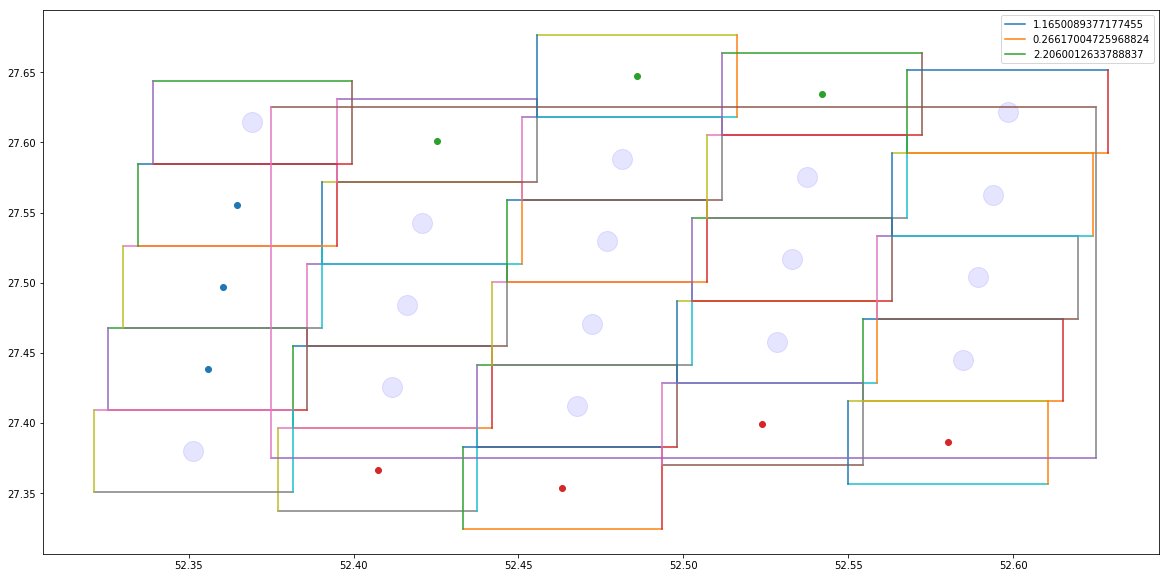

In [62]:
plot_cell(data_grid, lat = '52.5', lon = '27.5')

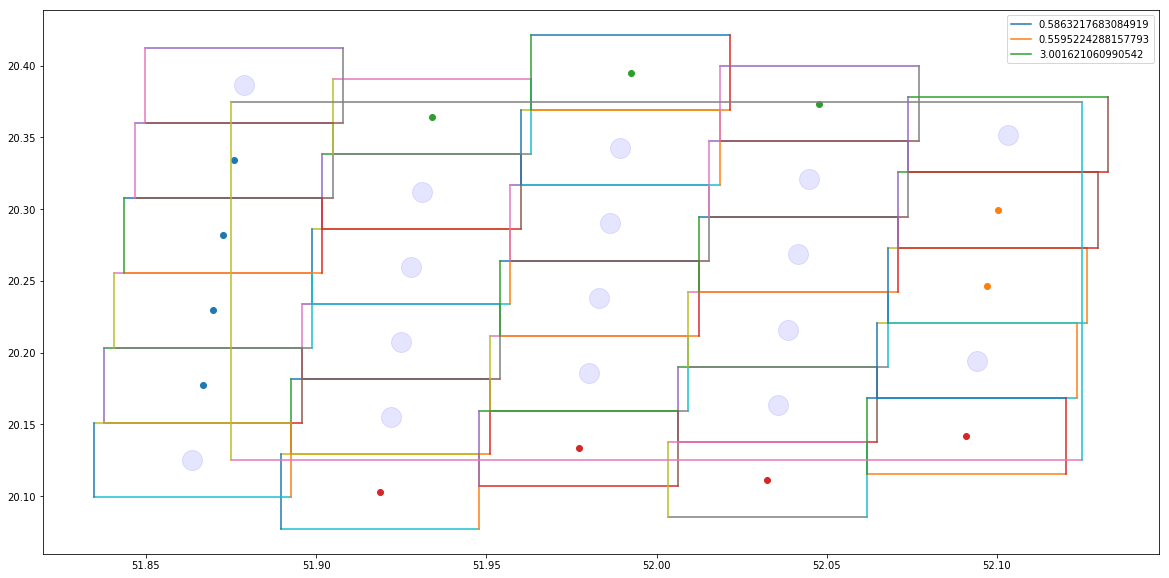

In [22]:
plot_cell(data_grid, lat = '52.0', lon = '20.25')

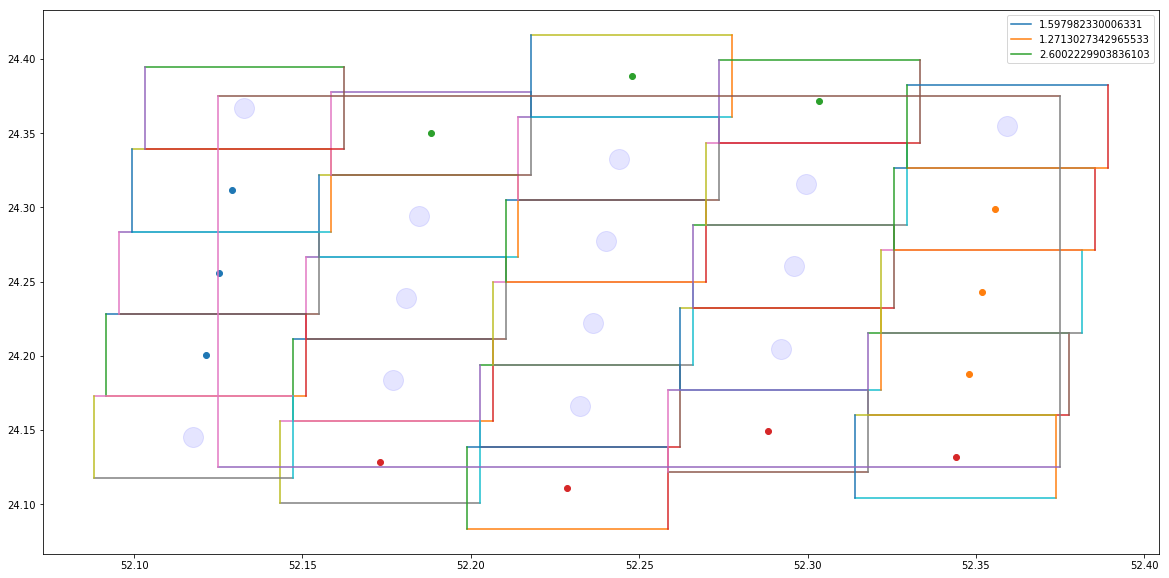

In [23]:
plot_cell(data_grid, lat = '52.25', lon = '24.25')

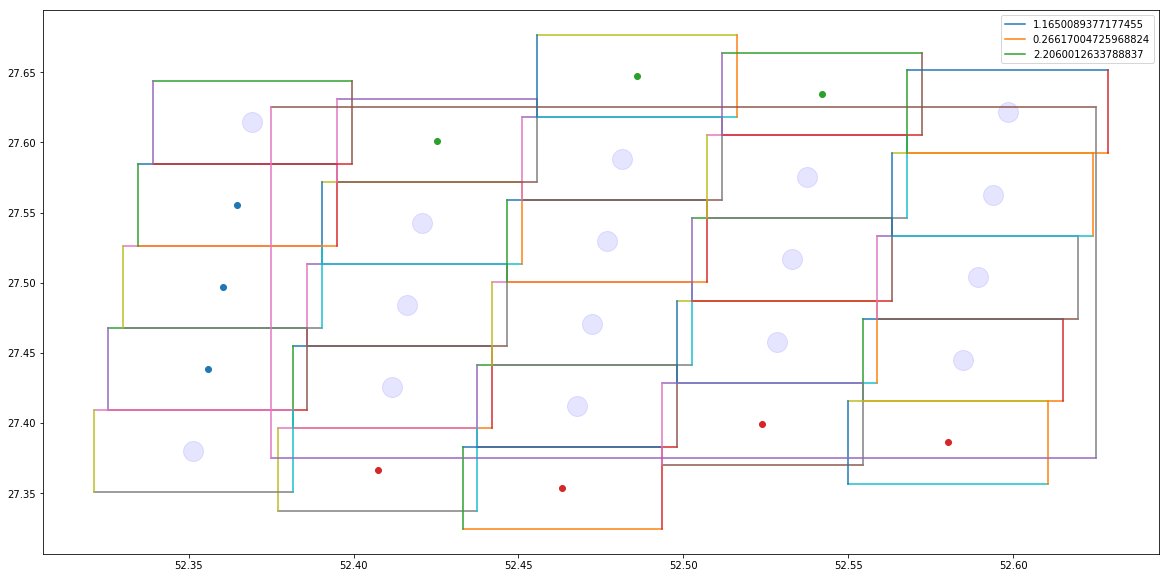

In [24]:
plot_cell(data_grid, lat = '52.5', lon = '27.5')

In [25]:
ex1['corner']['area']/np.max(ex1['centre']['area'])

array([0.06331242, 0.01380244, 0.12086488, 0.21874474, 0.02064275])

In [35]:
np.max(ex1['centre']['area'])

2.034644321165765

In [37]:
ex1['left']['area'], ex1['right']['area']

([0.7147221058417063,
  1.1800600715423395,
  1.6465586894180857,
  0.08687993239935704,
  0.5546515116454263,
  1.0237110183169975],
 [0.029484220787746755,
  1.587630948632793,
  1.1166099074366587,
  0.6443650389673439,
  0.17088541007173266,
  1.7300477404927852,
  1.2553262616965815])

# FIX:

* Doesn't look like the corners get deleted from the subsets 
* Deletes wrong indecies .. Looks like the righmost centres could contain some more data.
* Detect to corners and compute the difference 
    ** If you detect to corner. Does the calculated area overlap or or is it just the individual contributions.
* file that readscloud maska and calculate fraciot

fraction_down = (cloud_mask_array[idx_down_boundary][sub_section_down]*area_grid_cell(lat_down,
                                                                                      dlat_down,
                   
                   dlon_down)).sum()*era_AREA/

In [ ]:
era5_lat = np.linspace(float(lat)-0.25/2, float(lat)+0.25/2, 100) 
era5_lon = np.linspace(float(lon)-0.25/2, float(lon)+0.25/2, 100) 

plt.plot(np.ones(100)*era5_lon[0], era5_lat)
plt.plot(np.ones(100)*era5_lon[-1], era5_lat)

plt.plot(era5_lon, np.ones(100)*era5_lat[0])
plt.plot(era5_lon, np.ones(100)*era5_lat[-1])
#plt.plot(era5_lon)